In [1]:
import numpy as np
import tensorflow as tf
import graph_nets as gn
import sonnet as snt
import matplotlib.pyplot as plt
import math
import time
import datetime
import gc
import os
import sys
import pickle

#from pysr import pysr

from simulator import read_orbits, base_classes
from data.solar_system_names import *
from ml_model import *

sys.modules['base_classes'] = base_classes
print('Started')

tf.config.list_physical_devices('CPU')
tf.config.run_functions_eagerly(False)


Metal device set to: Apple M1
Started


2022-03-08 17:03:27.645816: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-08 17:03:27.645899: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Global Constants

In [2]:
start_time = time.time()

# Global constants
AU = 149.6e6 * 1000 # Astronomical Unit in meters.
DAY = 24*3600. # Day in seconds
YEAR = 365.25*DAY #Year
delta_time = (0.5/24.) # 2 hours
MSUN = 1.9885e+30
MEARTH = 5.9724e+24
G = 6.67428e-11/AU**3*MSUN*DAY**2

Training variables

In [3]:
# Training variables
patience = 5
d_patience = 0
noise_level = 0.01
log_every_iterations = 1000
num_training_iterations = 200000

# Do not change this
#total_time_traj = 40 #Years
#num_time_steps_total = int(total_time_traj/delta_time)
num_time_steps_tr = 520000 #An orbit for saturn is 129110 steps
num_time_steps_sr = 500
#num_batches = 13000
batch_size_tr = 32#num_time_steps_tr//num_batches
num_batches = num_time_steps_tr//batch_size_tr

Read the data

In [4]:
def force_newton(x, m1, m2):
    return G*m1*m2/np.linalg.norm(x, axis = -1, keepdims=True)**3.*x

In [5]:
dir_path = os.path.abspath('')
filename = os.path.join(dir_path, 'data/solar_system_data.pkl')
filehandler = open(filename, 'rb')
system = pickle.load(filehandler)
x = system.get_positions()
v = system.get_velocities()
data = np.concatenate([x, v], axis=-1)

# Get the acceleration
A = data[1:, :, 3:] - data[:-1, :, 3:]
data[:-1, :, 3:] = A / delta_time
data = data[:-1]

# For debugging, reduce size of validation data. Really speeds things up!
nval = 10000
data = data[:(num_time_steps_tr + nval)]

#masses = system.get_masses()/MSUN

# Split into training and validation
data_tr = data[:num_time_steps_tr]
data_val = data[num_time_steps_tr:]

# Shuffle the data
np.random.shuffle(data_tr)
np.random.shuffle(data_val)

data_tr = data_tr[:num_time_steps_tr]


In [6]:
num_time_steps_tr = len(data_tr)
num_time_steps_val = len(data_val)

# Do not change this
batch_size_tr = 16
num_batches = num_time_steps_tr // batch_size_tr

nedges = system.numEdges
D_tr_np = np.empty([len(data_tr), nedges, 3])
D_val_np = np.empty([len(data_val), nedges, 3])
#F_val = np.empty([len(data_val), nedges, 3])
k = 0
#names_edges = []
senders, receivers = [], []
for i in range(system.numPlanets):
    for j in range(system.numPlanets):
        if i > j:
            d_tr = data_tr[:, j, :3] - data_tr[:, i, :3]
            d_val = data_val[:, j, :3] - data_val[:, i, :3]
            D_tr_np[:, k, :] = d_tr
            D_val_np[:, k, :] = d_val
            #F_val[:, k, :] = force_newton(d_val, masses[i], masses[
                #j])  # cartesian_to_spherical_coordinates(d_val)
            #names_edges.append(names[j] + ' - ' + names[i])

            k += 1
            receivers.append(i)
            senders.append(j)

A_tr = data_tr[:, :, 3:]
A_val = data_val[:, :, 3:]
A_norm = np.std(A_tr)

D_tr_flat = np.reshape(D_tr_np, [-1, 3])
D_val_flat = np.reshape(D_val_np, [1, -1, 3])

A_tr_flat = np.reshape(A_tr / A_norm, [-1, 3])
A_val_flat = np.reshape(A_val / A_norm, [1, -1, 3])

D_tr = tf.convert_to_tensor(D_tr_flat, dtype="float32")
A_tr = tf.convert_to_tensor(A_tr_flat, dtype="float32")

D_tr_batches = tf.split(D_tr, num_batches)
A_tr_batches = tf.split(A_tr, num_batches)

D_val = tf.convert_to_tensor(D_val_flat, dtype="float32")
A_val = tf.convert_to_tensor(A_val_flat, dtype="float32")

train_ds = tf.data.Dataset.from_tensor_slices(
    (D_tr_batches, A_tr_batches))

test_ds = tf.data.Dataset.from_tensor_slices(
    (D_val, A_val))

norm_layer = Normalize_gn(cartesian_to_spherical_coordinates(D_tr))

In [7]:
A_tr = None
A_val = None
D_tr = None
#D_val = None
A_tr_flat = None
A_val_flat = None
D_tr_flat = None
#D_val_flat = None
A_tr_batches = None
D_tr_batches = None
data = None
data_tr = None
gc.collect()

0

In [8]:
setup_time = time.time()

In [12]:
checkpoint_filepath = './saved_models/orbits'

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            verbose = 1,
                                            patience=20,
                                            #baseline = 0.1,
                                            restore_best_weights=False)
# Restore best weights not working, but found way around using checkpoint

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                 save_weights_only=False,
                                                save_best_only=True,
                                                 verbose=0)
model = LearnForces(system.numPlanets, senders, receivers, norm_layer, noise_level = noise_level)

#model.compile(run_eagerly=True)
model.compile()

In [ ]:
model.fit(train_ds, 
          epochs = 1000, 
          verbose=2, 
          callbacks=[early_stopping, checkpoint], 
          validation_data=test_ds
         )


Epoch 1/1000


2022-03-09 10:47:56.610423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-09 10:47:57.028114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-09 10:58:49.899577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ./saved_models/orbits/assets


INFO:tensorflow:Assets written to: ./saved_models/orbits/assets


32500/32500 - 660s - loss: 443321449009018837139456.0000 - val_loss: 24576674746073088.0000 - 660s/epoch - 20ms/step
Epoch 2/1000


In [ ]:
model.load_weights(checkpoint_filepath)

model.evaluate(test_ds)

In [ ]:
j=0
learned_masses = model.logm_planets.numpy() - model.logm_planets.numpy()[j]
for i in range(nplanets):
    print(f'{names[i]}, {np.log10(masses[i]/masses[j]):.2f}, {learned_masses[i]:.2f}, {abs(np.log10(masses[i]/masses[j]) -learned_masses[i])/abs(np.log10(masses[i])):.2f}')

train_time = time.time()

# Evaluate on validation data

In [13]:
ap ,fp = model(D_val_flat[0], extract = True)

In [14]:
F_val_new = np.empty([len(data_val), nedges, 3])
k=0
for i in range(nplanets):
    for j in range(nplanets):
        if i > j:
            d_val = data_val[:,j,:3] - data_val[:,i,:3]
            F_val_new[:,k,:] = force_newton(d_val, 10**learned_masses[i], 10**learned_masses[j]) #cartesian_to_spherical_coordinates(d_val)
            k+=1

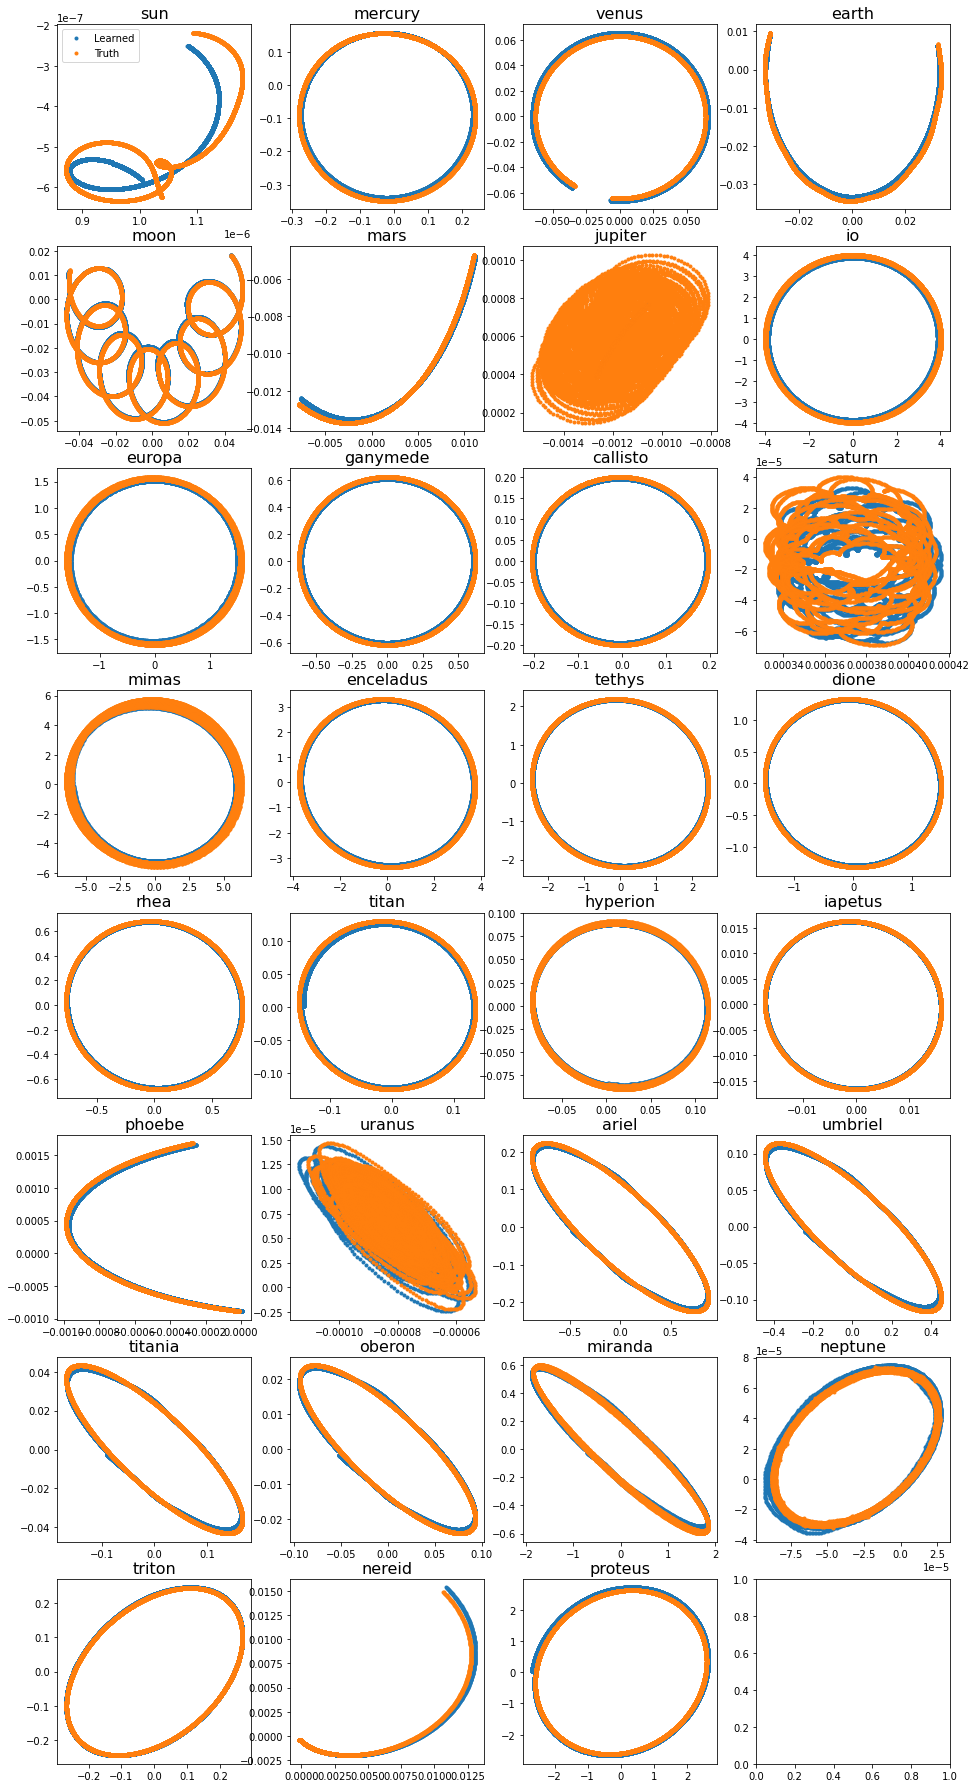

In [15]:
nrows = math.ceil(nplanets/4)
fig, ax = plt.subplots(nrows, 4, figsize = (16, 4*nrows))
for i in range(nplanets):
    ax[i//4, i%4].set_title(names[i], fontsize = 16)
    ax[i//4, i%4].plot(ap[:,i,0], ap[:,i,1], '.', label = 'Learned')
    ax[i//4, i%4].plot(data_val[:,i,3]/A_norm, data_val[:,i,4]/A_norm, '.', label = 'Truth')

ax[0,0].legend()
#plt.savefig('/Users/Pablo/Desktop/full_learnedmasses.png')

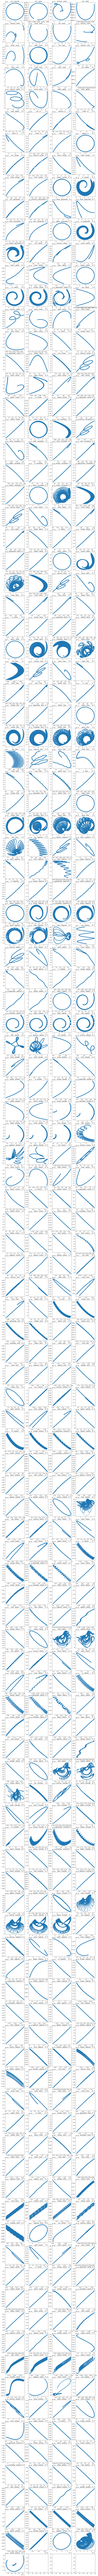

In [16]:
nrows = math.ceil(nedges/4)
fig, ax = plt.subplots(nrows, 4, figsize = (16, 4*nrows))
for i in range(nedges):
    ax[i//4, i%4].set_title(names_edges[i])
    #ax[i//4, i%4].plot(F_val_new[:,i,0], F_val_new[:,i,1], '.')
    #ax[i//4, i%4].plot(fp[:,i,0]*n1/n2, fp[:,i,1]*n1/n2, '.')
    ax[i//4, i%4].plot(fp[:,i,0], fp[:,i,1], '.')
#plt.savefig('/Users/Pablo/Desktop/forces_learnedmasses.png')

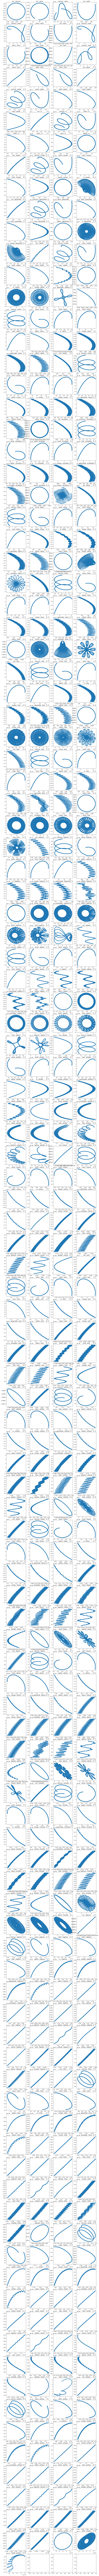

In [17]:
nrows = math.ceil(nedges/4)
fig, ax = plt.subplots(nrows, 4, figsize = (16, 4*nrows))
for i in range(nedges):
    ax[i//4, i%4].set_title(names_edges[i])
    ax[i//4, i%4].plot(F_val[:,i,0]*1e8, F_val[:,i,1]*1e8, '.')
    #ax[i//4, i%4].plot(fp[:,i,0]*n1/n2, fp[:,i,1]*n1/n2, '.')
    #ax[i//4, i%4].plot(fp[:,i,0], fp[:,i,1], '.')
#plt.savefig('/Users/Pablo/Desktop/forces_learnedmasses.png')

In [18]:
plot_time = time.time()

In [19]:
X = np.zeros([nval, nedges,9])
X[:,:,2:5] = D_val_np
X[:,:,5] = np.linalg.norm(D_val_np, axis = -1)
X[:,:,6:] = fp
k=0
for i in range(nplanets):
    for j in range(nplanets):
        if i > j:
            X[:,k,0] = 10**(learned_masses[i])
            X[:,k,1] = 10**(learned_masses[j])
            #print(fp[0,k,0], X[0,k,0]*X[0,k,1]*X[0,k,2]/X[0,k,5]**3.)
            k+=1 
            
N = 500
ii = np.random.choice(nval, N, replace = False)
X = X[ii]

X[:,:,2:5], X[:,:,6:] = rotate_data(X[:,:,2:5], X[:,:,6:], uniform = False)

X = np.reshape(X, [N*nedges,9])

In [20]:
for i in range(len(X)):
    r = np.random.rand()
    if r > 0.5:
        X[i,0], X[i,1]  = X[i,1], X[i,0]

In [21]:
from sklearn.neighbors import KernelDensity
norm_F = np.linalg.norm(X[:,6:], axis = -1)
X_density = norm_F[:, None]
bin_width = np.max(X_density)/30
kde = KernelDensity(bandwidth=bin_width,
                    kernel='cosine') #Want finite cutoff so not too expensive!
kde.fit(X_density)

KernelDensity(bandwidth=0.00010013720645288762, kernel='cosine')

In [22]:
grid = np.linspace(0.0, 1.5e-3, num=1000)
density_grid = np.exp(kde.score_samples(grid[:, None]))
grid_idx = np.argmax((X_density < grid[1:]) & (X_density > grid[:-1]), axis=1)
density_values = density_grid[grid_idx]
inv_density = 1 / density_values
inv_density /= inv_density.sum()
np.random.seed(1)
idx_for_pysr = np.random.choice(np.arange(len(X)), size=(1000,), p=inv_density)
X_pysr = X[idx_for_pysr]

In [23]:
y = X_pysr[:,6] #F_x
#X[:, [0, 1]] = np.exp(X[:, [0, 1]])/1e23 #re-scale to prevent precision issues, since pysr uses 32-bit floats
y /= np.std(y)                                 #same as above

m_std = np.std(X_pysr[:,:2])
x_std = np.std(X_pysr[:,2:5])
X_pysr[:,:2]/= m_std
X_pysr[:,2:]/= x_std

kwargs = dict(populations=64, binary_operators="+ * - /".split(" "),
          unary_operators=[], temp_equation_file=True,
          progress=False, procs=4, annealing=False, maxsize=40, useFrequency=True,  
          variable_names = ['m0', 'm1', 'x', 'y', 'z', 'r'],
          optimizer_algorithm="BFGS",
          optimizer_iterations=10,
          optimize_probability=1.0,)
equations=pysr(X_pysr[:,:6], y, **kwargs)

Running on julia -O3 /var/folders/g2/89155hgd7fq1_lb47r__q4240000gn/T/tmppgebs7f7/runfile.jl
Activating environment on workers.
      From worker 3:	 Activating environment at `~/Projets/orbits_tf2/conda-env/lib/python3.7/site-packages/Project.toml`
      From worker 5:	 Activating environment at `~/Projets/orbits_tf2/conda-env/lib/python3.7/site-packages/Project.toml`
      From worker 4:	 Activating environment at `~/Projets/orbits_tf2/conda-env/lib/python3.7/site-packages/Project.toml`
      From worker 2:	 Activating environment at `~/Projets/orbits_tf2/conda-env/lib/python3.7/site-packages/Project.toml`
Importing installed module on workers...Finished!
Testing module on workers...Finished!
Testing entire pipeline on workers...Finished!
Started!

Cycles per second: 1.130e+01
Progress: 1 / 6400 total iterations (0.016%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.961e-02  -0.000e+00  0.0020922422
3           1.958e-


Cycles per second: 5.490e+03
Progress: 45 / 6400 total iterations (0.703%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.961e-02  -0.000e+00  0.0020922422
3           1.958e-02  6.336e-04  (0.0008700832 * x)
5           1.776e-02  4.887e-02  ((x * m0) * 0.08632434)
9           1.186e-02  1.009e-01  ((0.11255389 * ((x * m0) / r)) / 0.95853895)
15          1.740e-05  1.087e+00  ((((814.3272 * m0) * m1) * x) * (((0.37332988 / r) / r) / r))


Cycles per second: 5.410e+03
Progress: 46 / 6400 total iterations (0.719%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.961e-02  -0.000e+00  0.0020922422
3           1.958e-02  6.336e-04  (0.0008700832 * x)
5           1.776e-02  4.887e-02  ((x * m0) * 0.08632434)
9           1.186e-02  1.009e-01  ((0.11255389 * ((x * m0) / r)) / 0.95853895)
15          1.740e-05  1.087e+00  ((((814.3272 * m0) * m1) * x) * (((0.37332988

In [24]:
from pysr import best
best(equations)

304.012675856736*m0*m1*x/r**3

In [25]:
sr_time = time.time()

In [33]:
print('Total time: ', str(datetime.timedelta(seconds=sr_time - start_time)))
print('---------------')
print('Time to set up data: ', str(datetime.timedelta(seconds=setup_time - start_time)))
print('Time for training: ', str(datetime.timedelta(seconds=train_time - setup_time)))
print('Time for plotting: ', str(datetime.timedelta(seconds=plot_time - train_time)))
print('Time for symbolic regression: ', str(datetime.timedelta(seconds=sr_time - plot_time)))

Total time:  4:36:25.192605
---------------
Time to set up data:  0:03:55.302859
Time for training:  3:18:34.579545
Time for plotting:  0:02:32.826115
Time for symbolic regression:  1:11:22.484086


# TO DO:

### To finish the project
- Working!

### To clean the model
- Improve plotting

# Requirements
- The graphnets tensorflow 2 installation
- pysr
- matplotlib

# Debugging (ignore)

In [ ]:
from tensorflow.python.keras.utils import tf_utils

In [ ]:
loss_tr = 1

i = 0
while not np.isnan(loss_tr):
    model = LearnForces(nplanets, senders, receivers, norm_layer, noise_level = noise_level)
    model.compile(run_eagerly=True)

    model.fit(train_ds, 
              verbose = 2,
              epochs = 1,
              steps_per_epoch = 10,
              callbacks=[
                    tf.keras.callbacks.TerminateOnNaN()]
              #validation_data=test_ds
             )
    
    loss_tr = tf_utils.to_numpy_or_python_type(model.evaluate(ini_ds, verbose = 0))
    i+=1
    if i>1000: 
        print('SUCCESS!')
        break
    #print(loss_tr)




In [ ]:
loss_tr = np.NaN

while np.isnan(loss_tr):
    model = LearnForces(nplanets, senders, receivers, norm_layer, noise_level = noise_level)
    model.compile(run_eagerly=True)

    model.fit(train_ds, 
              verbose = 2,
              epochs = 1,
              steps_per_epoch = 10,
              callbacks=[
                    tf.keras.callbacks.TerminateOnNaN()]
              #validation_data=test_ds
             )
    
    loss_tr = tf_utils.to_numpy_or_python_type(model.evaluate(ini_ds, verbose = 0))
    #print(loss_tr)

